In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import tensorflow_hub as hub
import tensorflow_text

from transformers import BertTokenizer, BertModel
import torch

C:\Users\Brad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print(type(last_hidden_states))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class 'torch.Tensor'>


In [3]:
last_hidden_states = last_hidden_states.detach().numpy()

In [4]:
print(last_hidden_states[0][0].shape)

(768,)


In [5]:
from datasets import load_dataset

dataset = load_dataset("xnli", "all_languages")

Reusing dataset xnli (C:\Users\Brad\.cache\huggingface\datasets\xnli\all_languages\1.1.0\818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)
100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 392702
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 5010
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2490
    })
})

In [7]:
xnli = dataset["train"]["premise"][:100]

In [8]:
xnli[0]

{'ar': '- و قد ال كريم المفاهيمية اثنان اساسيين - المنتج والجغرافيا .',
 'bg': 'концептуално крем краде има две основни измерения - продукт и география .',
 'de': 'Konzeptionell cream abschöpfen hat zwei grundlegende Dimensionen - Produkt und Geographie .',
 'el': 'Η εννοιολογικά κρέμα κρέμα έχει δύο βασικές διαστάσεις - προϊόν και γεωγραφία .',
 'en': 'Conceptually cream skimming has two basic dimensions - product and geography .',
 'es': 'Los robando de crema conceptualmente tienen dos dimensiones básicas : producto y geografía .',
 'fr': "L' écrémage conceptuel de la crème a deux dimensions fondamentales : le produit et la géographie .",
 'hi': 'Conceptually क ् रीम एंजलिस में दो मूल आयाम हैं - उत ् पाद और भूगोल ।',
 'ru': 'Концептуально крем крем имеет два основных измерения - продукт и география .',
 'sw': 'Sakata cream ya conceptually ina vipimo viwili vya msingi - bidhaa na geography .',
 'th': 'ท่า ครีม ยักยอก มี สอง มิติ พื้นฐาน   -   สินค้า และ ภูมิศาสตร์',
 'tr': 'Kavramsal 

In [13]:
# new_models in sentence transformers org
miniLM = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
distil = "sentence-transformers/distiluse-base-multilingual-cased-v2"
xlm = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"


In [16]:
from sentence_transformers import SentenceTransformer
miniLM_model = SentenceTransformer(miniLM)
distil_model = SentenceTransformer(distil)
xlm_model = SentenceTransformer(xlm)

Downloading: 100%|██████████| 114/114 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 1.58M/1.58M [00:00<00:00, 2.89MB/s]
Downloading: 100%|██████████| 2.38k/2.38k [00:00<00:00, 149kB/s]
Downloading: 100%|██████████| 341/341 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 539M/539M [03:05<00:00, 2.91MB/s] 
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 6.62kB/s]
Downloading: 100%|██████████| 112/112 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 1.96M/1.96M [00:00<00:00, 2.92MB/s]
Downloading: 100%|██████████| 531/531 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 996k/996k [00:00<00:00, 2.83MB/s]
Downloading: 100%|██████████| 190/190 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 3.74k/3.74k [00:00<?, ?B/s]
Downloading: 100%|██████████| 229/229 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 1.11G/1.11G [06:41<00:00, 2.77MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 6.77kB/s]
Downloading: 100%|██████████| 5.07M/5.07M [00:01<00:00, 2.98MB/s]
Downloading: 100%|████████

In [23]:
for i in xnli[0]:
    print(i + " " + xnli[0][i])

ar - و قد ال كريم المفاهيمية اثنان اساسيين - المنتج والجغرافيا .
bg концептуално крем краде има две основни измерения - продукт и география .
de Konzeptionell cream abschöpfen hat zwei grundlegende Dimensionen - Produkt und Geographie .
el Η εννοιολογικά κρέμα κρέμα έχει δύο βασικές διαστάσεις - προϊόν και γεωγραφία .
en Conceptually cream skimming has two basic dimensions - product and geography .
es Los robando de crema conceptualmente tienen dos dimensiones básicas : producto y geografía .
fr L' écrémage conceptuel de la crème a deux dimensions fondamentales : le produit et la géographie .
hi Conceptually क ् रीम एंजलिस में दो मूल आयाम हैं - उत ् पाद और भूगोल ।
ru Концептуально крем крем имеет два основных измерения - продукт и география .
sw Sakata cream ya conceptually ina vipimo viwili vya msingi - bidhaa na geography .
th ท่า ครีม ยักยอก มี สอง มิติ พื้นฐาน   -   สินค้า และ ภูมิศาสตร์
tr Kavramsal krem kaymağını iki temel boyutu vardır - ürün ve coğrafya .
ur ارضیات کی ناپیدی او

In [28]:
# loop through the data and get word embeddings
embed_list = []

for idx, i in enumerate(xnli):
    new_entry = {}
    for i in xnli[idx]:
        lang_id = i
        lang_value = xnli[idx][i]

        embeddings = miniLM_model.encode(lang_value)

        new_entry[lang_id] = embeddings
    embed_list.append(new_entry)

In [41]:
for i in range(0, 2):
    print(i)

0
1


In [48]:
test1 = [0, 1, 2, 2,3]
test2 = [2, 4, 5, 5,4]
t3 = np.array(test1) - np.array(test2)
print(t3 ** 2)

[4 9 9 9 1]


In [54]:
diff_sums = []
def wcss():
    vectors = list(embed_list[0].values())

    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(vectors)
        y_kmeans = kmeans.predict(vectors)

        means = []
        for m in range(0, i):
            sublist = []
            for idx, y in enumerate(y_kmeans):
                if y == m:
                    sublist.append(vectors[idx])
            means.append(sublist)
        
        avgs = []
        for a in means:
            sub_avg = np.average(a)
            avgs.append(sub_avg)
        
        sum = np.zeros((384,))
        for idx, v in enumerate(vectors):
            avg_group = y_kmeans[idx]
            avg = avgs[avg_group]
            diff = (v - avg) ** 2
            sum = sum + diff

        diff_sums.append(np.sum(sum))

wcss()

In [55]:
diff_sums

[212.54451463151594,
 212.54434911185479,
 212.54450392102842,
 212.54356387253893,
 212.5433746753605,
 212.54337183148908,
 212.54336181437282,
 212.54334417896743,
 212.54333221029523,
 212.5433312248958,
 212.543170908395,
 212.54317091097153,
 212.54307658401933,
 212.54303155087462]

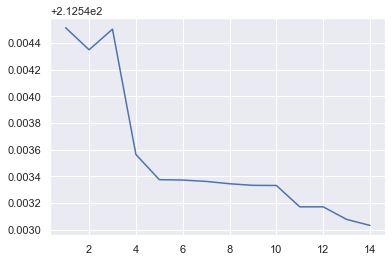

In [56]:
import matplotlib.pyplot as plt

x_values = [i for i in range(1, 15)]
y_values = diff_sums
plt.plot(x_values, y_values)  #draw the plot
plt.show()   #show the plot

In [38]:
# cluster the sentence blocks using k-means and wss
from sklearn.cluster import KMeans



kmeans = KMeans(n_clusters=3)
vectors = list(embed_list[0].values())
kmeans.fit(vectors)
y_kmeans = kmeans.predict(vectors)

In [49]:
np.shape(vectors[0])

(384,)

In [42]:
y_kmeans

array([1, 1, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1])

In [44]:
means = []
for m in range(0, 3):
    sublist = []
    for idx, y in enumerate(y_kmeans):
        if y == m:
            #vectors[idx]
            sublist.append(y)
    means.append(sublist)
means

[[0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2]]

In [19]:
embeddings = distil_model.encode("I am a sentence")
print(embeddings.shape)

(512,)


In [9]:
# OLD MODELS

# tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
# m_bert = BertModel.from_pretrained("bert-base-multilingual-cased")

# from transformers import XLMRobertaTokenizer
# from transformers import XLMRobertaModel

# x_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
# xlm_r = XLMRobertaModel.from_pretrained("xlm-roberta-base")
# # distilbert-base-multilingual-cased

# d_tokenizer = BertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
# distil = BertModel.from_pretrained("distilbert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
